In [20]:
work_dir = '/media/Data/work/nf'

# %%load parcellation (Yeo? / Shen?)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nilearn
from nilearn import input_data
from nilearn import plotting
import scipy
import seaborn as sns
import glob

In [2]:
# shen
atlas_filename = '/home/or/Downloads/shenPar/shen_1mm_268_parcellation.nii.gz'
atlas_labes = pd.read_csv('/home/or/Downloads/shenPar/shen_268_parcellation_networklabels.csv')
colors = pd.read_csv('/home/or/Downloads/shenPar/shen_268_parcellation_networklabels_colors.csv')
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

atlas_labes = np.array(atlas_labes)
atlas_labes.shape

(268, 2)

In [47]:
# extract RS data and create vector for each subject
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf','white_matter', 'framewise_displacement', 'dvars', 'std_dvars',
                          'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
                        ]] # can add 'global_signal' also ,
     # change NaN of FD to zero
    finalConf = np.array(finalConf.fillna(0.0))
    #finalConf[0,2] = 0 # if removing FD than should remove this one also
    return finalConf
#from nilearn.input_data import NiftiMasker
    # define masker here

from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,t_r=2, high_pass=.01, low_pass=0.1,
                           smoothing_fwhm=6, mask_img=group_mask
                           )

from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')


In [48]:
subject_list = subject_list = ['1319','1450','1524','1525','1527','1528','1547','1551','1555'] #'1263',

func_template = '/media/Data/Lab_Projects/neurofeedback/neuroimaging/NF_BIDS/derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-rest1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'
confound_template = '/media/Data/Lab_Projects/neurofeedback/neuroimaging/NF_BIDS/derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-rest1_desc-confounds_regressors.tsv'
mask_template = '/media/Data/Lab_Projects/neurofeedback/neuroimaging/NF_BIDS/derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-rest1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz'

In [23]:
brainmasks = glob.glob('/media/Data/Lab_Projects/neurofeedback/neuroimaging/NF_BIDS/derivatives/fmriprep/sub-*/ses-[1,2]/func/sub-*_ses-[1,2]_task-rest*_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz')
## generate brain mask


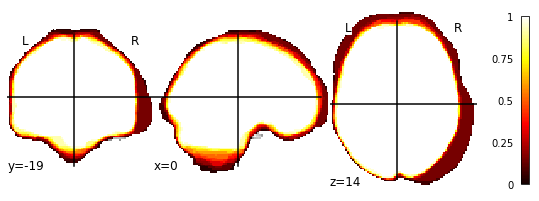

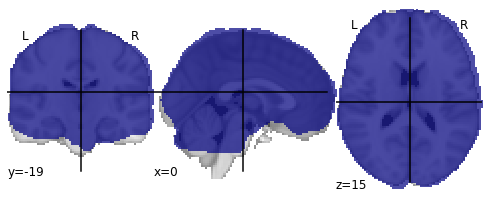

In [30]:
%matplotlib inline
#for mask in brainmasks:
 #   nilearn.plotting.plot_roi(mask)
    
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.98", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)
 

In [28]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[10,11,10],[5,5,5]])
print(a*b)
print(np.multiply(a,b))

[[10 22 30]
 [20 25 30]]
[[10 22 30]
 [20 25 30]]


In [46]:
#nilearn.image.math_img("np.multiply(img)", img = brainmasks)
a = nilearn.image.get_data(group_mask)
sum(a[a==1])

219847

In [49]:
### Run this only to extract timeseries from the start if it was extracted already - run next cell only
ses = '1'
for sub in subject_list:
    print(f'Analyzing subject {sub}')
    confound = confound_template.format(sub=sub, ses = ses)    
    filename = func_template.format(sub=sub, ses = ses)
   
    try:
        timeseries_each_subject = masker.fit_transform(filename, confounds=removeVars(confound))
        np.save(work_dir + '/sub-'+ sub + '_session2CorrSphere',timeseries_each_subject)
    except:
        print (f'Subject {sub} have no data file')
    

Analyzing subject 1319
Subject 1319 have no data file
Analyzing subject 1450
Subject 1450 have no data file
Analyzing subject 1524
Analyzing subject 1525
Analyzing subject 1527
Analyzing subject 1528
Analyzing subject 1547
Analyzing subject 1551
Analyzing subject 1555


In [39]:
timeseries_each_subject.shape

(150, 268)

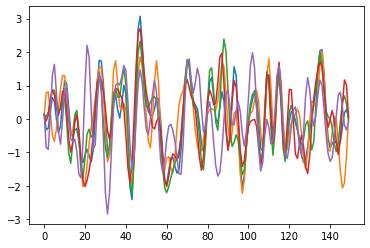

In [50]:
plt.plot(timeseries_each_subject[:,0:5])

In [51]:
correlation_matrix = correlation_measure.fit_transform([timeseries_each_subject])[0]

(<matplotlib.image.AxesImage at 0x7f314e3a0f10>,)

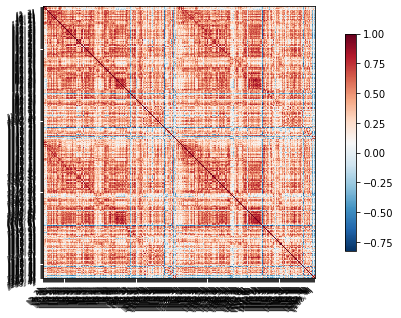

In [52]:
plotting.plot_matrix(correlation_matrix, labels=atlas_labes, colorbar=True),
                     #vmax=0.8, vmin=-0.8)


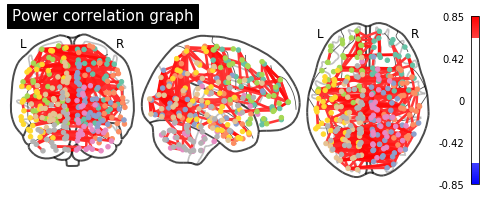

In [43]:
# Tweak edge_threshold to keep only the strongest connections.
#mean_corrMat = np.mean(correlations, axis=0)
plotting.plot_connectome(correlation_matrix, coords, title='Power correlation graph',
                         edge_threshold='99%', node_size=20, colorbar=True)

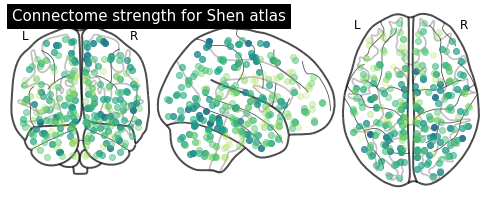

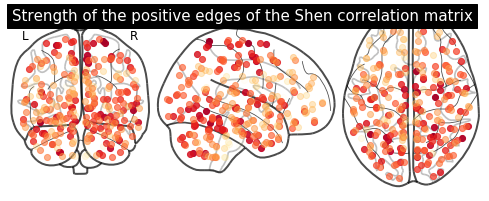

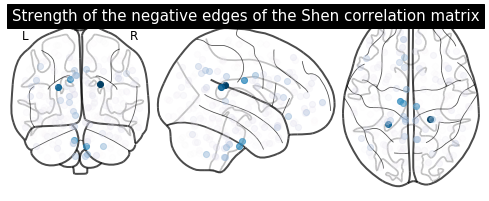

In [44]:
## plot strength
plotting.plot_connectome_strength(
    correlation_matrix, coords, title='Connectome strength for Shen atlas'
)

## just positive
from matplotlib.pyplot import cm

# plot the positive part of of the matrix
plotting.plot_connectome_strength(
    np.clip(correlation_matrix, 0, correlation_matrix.max()), coords, cmap=cm.YlOrRd,
    title='Strength of the positive edges of the Shen correlation matrix'
)

# plot the negative part of of the matrix
plotting.plot_connectome_strength(
    np.clip(correlation_matrix, correlation_matrix.min(), 0), coords, cmap=cm.PuBu,
    title='Strength of the negative edges of the Shen correlation matrix'
)
